# 1. Load libraries

In [1]:
import spotipy, pandas as pd
from spotipy.oauth2 import SpotifyOAuth
from sklearn import preprocessing as pre
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import seaborn as sns
from itertools import combinations, permutations
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# 2. Spotify authorization and some sample playlists to play around with

###### You can replace the linked playlists below with your own to play around with, or not. The "big test playlist" is over 6,000 songs (basically just my "liked songs" and some random other music). In the python file version of this, the playlist url is entered in console instead of copy-pasted directly into the code.

In [2]:
scope = 'playlist-modify-public playlist-modify-private'
red_url = 'http://localhost:8080'
playlist = 'https://open.spotify.com/playlist/37i9dQZEVXcD0rEV1cHpue?si=cba0a3fd1e1a47b4' #Discover Weekly
#playlist = 'https://open.spotify.com/playlist/0zZlkqz8ZRPsZd0kARwia9?si=2b1315ae6d884cb5' # big test playlist

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(redirect_uri=red_url,scope=scope))
user = sp.me()['id']

# 3. Song and feature extraction

##### sp.playlist_tracks returns json-formatted information about the songs in a playlist, up to 100 at a time
##### sp.audio_features returns json-formatted audio features about a list of songs, up to 50 at a time

In [3]:
offset = 0
song_ids = []
while True:
    songs = sp.playlist_tracks(playlist_id=playlist, offset=offset, fields='items.track.id', limit=100)['items']
    if len(songs) == 0:
        break
    song_ids += [d['track']['id'] for d in songs]
    offset += len(songs)

In [4]:
offset = 0
limit = 50
song_feats = []
while offset < len(song_ids):
    song_feats += sp.audio_features(tracks=song_ids[offset: offset + limit])
    offset += limit

In [5]:
df_feats = pd.DataFrame(song_feats).drop(['type', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'key', 'time_signature'], axis=1)

##### As a brief note, features already normed by Spotify like "energy" and "valence" are also normed below, as all songs spotify has being normed between 0 and 1 does not guarantee that same even distribution within the provided playlist

In [6]:
to_norm = df_feats[['loudness', 'tempo', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'danceability', 'energy', 'valence']].values
scaler = pre.MinMaxScaler()
normed = scaler.fit_transform(to_norm)
df_normed = pd.DataFrame(normed).rename(columns={0: 'loudness', 1: 'tempo', 2: 'speechiness', 3: 'acousticness', 4: 'instrumentalness', 5: 'liveness', 6: 'danceability', 7: 'energy', 8: 'valence'})

In [7]:
df_feats.drop(['loudness', 'tempo', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'danceability', 'energy', 'valence'], axis=1, inplace=True)

In [8]:
# We need the dataframe with the ids preserved later for playlist creation, and create one with song ids as the index for purposes of clustering
df_total = df_feats.join(df_normed)
df_feats = df_total.set_index('id')

# 4. Choosing features to cluster on

##### We create a heatmap of correlations below. Keeping in mind some of the stronger correlations, like loudness and acousticness or danceability and valence, is important when choosing features in order to avoid clustering using those feature combinations.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


<AxesSubplot:>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


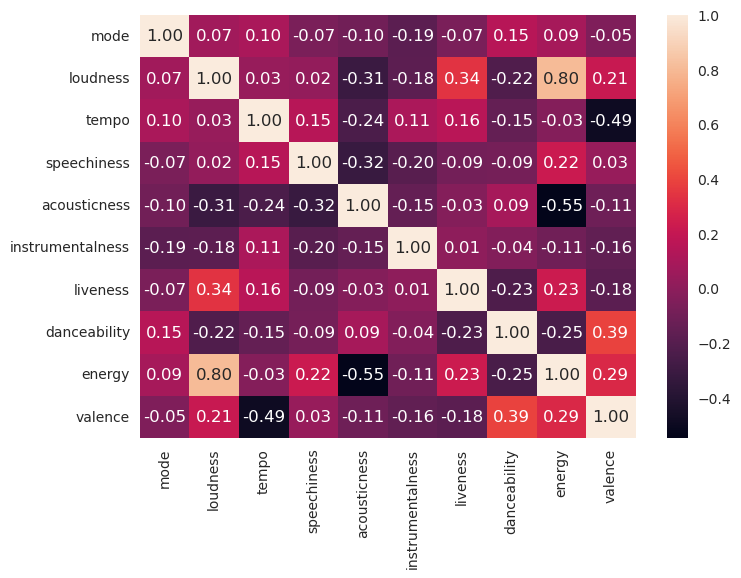

In [9]:
sns.heatmap(df_feats.corr(), annot=True, fmt='.2f')

##### The code below tests all possible combinations of 3+ audio features, running each with 2-6 clusters, in order to see the optimal elbow scores and corresponding silhouette scores for each.

In [ ]:
n_clusters = [2, 3, 4, 5, 6, 7, 8]
cols = list(df_feats)
feats = 3
combo, score, value = [], [], []
while feats <= len(cols):
    combos = list(combinations(cols, feats))
    combo += combos
    for comb in combos:
        subset = df_feats[list(comb)]
        model = KElbowVisualizer(KMeans(), k=(min(n_clusters), max(n_clusters)), metric='silhouette', timings=False)
        model.fit(subset.values)
        score.append(model.elbow_score_)
        value.append(model.elbow_value_)
    feats += 1
    
output = {'combo': combo, 'score': score, 'elbow': value}
df_combos = pd.DataFrame(output)

##### Below we output only the feature combinations with silhouette scores above 0.6 and that have at least 3 clusters. The reason on having a minimum of 3 clusters is subjective; in my opinion, splitting the inputted test playlists into only two groups does not adequately reflect the variety of music they contain (especially for the larger test playist; Taylor Swift, the instrumental tracks from the Frozen soundtrack, A$AP Ferg, and Stan Rogers seem like they should be split into more than just two groups). If you want to run the same code but try clustering on different features, play around with these conditions.

##### As we see, the combination of mode, loudness, and instrumentalness performs best. Intuitively, this makes sense. Mode indicates whether the song is in a major or minor key which is helpful for broadly categorizing songs (there aren't a lot of super-happy songs in minor keys, or a lot of super-sad ones in major keys). Liveness . Instrumentalness helps capture a lot of other information, i.e. genre (pop songs should have relatively similar instrumentalness scores, as should rap, rock, lo-fi, etc.) without being limited by human definition of that information.

In [ ]:
df_options = df_combos[(df_combos['elbow'] >= 3) & (df_combos['score'] > 0.6)].sort_values(by=['score'], ascending=False)

In [ ]:
df_options

# 5. Playlist creation

##### We create dataframes containing only the desired features. Additionally, we manually set the number of clusters; app.py automatically identifies the ideal number of clusters because the playlists it gets passed are varied. The for loop at the end then creates the smaller playlists.

In [ ]:
df_feats_cluster = df_feats[['loudness', 'mode', 'instrumentalness']]
df_total_cluster = df_total[['id','loudness', 'mode', 'instrumentalness']]

In [ ]:
num_clusts = 3
mod = KMeans(n_clusters=num_clusts).fit(df_feats_cluster.values)

In [ ]:
clusters = {'cluster': mod.labels_}
df_clustered = df_total_cluster.join(pd.DataFrame(clusters))

In [ ]:
for i in range(num_clusts):
    songs = list(df_clustered['id'][df_clustered['cluster'] == i])
    name = f'created_playlist_{i}'
    current_playlists = []
    offset = 0
    while True:
        playlists = sp.current_user_playlists(limit=50, offset=offset)['items']
        if len(playlists) == 0:
            break
        current_playlists += [d['name'] for d in playlists]
        offset += len(playlists)
    if name in current_playlists:
        continue
    sp.user_playlist_create(user=user, name=name)
    new = sp.current_user_playlists(limit=1)['items'][0]['uri']
    if len(songs) > 100:
        j = 0
        while j < (len(songs)//100 + 1):
            sub_songs = songs[100*j:100*(1+j)]
            sp.user_playlist_add_tracks(user=user, playlist_id=new, tracks=sub_songs)
            j += 1
        sp.user_playlist_add_tracks(user=user, playlist_id=new, tracks=songs[-(len(songs)%100):])
    else:
        sp.user_playlist_add_tracks(user=user, playlist_id=new, tracks=songs)